In [1]:
!pip install "numpy<2.0" "opencv-python<4.11" "opencv-python-headless<4.11" ultralytics --quiet

print(" Environment configured successfully.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 39.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --no-deps ultralytics

In [3]:
import os
import json
import shutil
import yaml
from tqdm.notebook import tqdm
from ultralytics import YOLO
import glob
import random
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
BASE_DIR = "/kaggle/input/solesensei_bdd100k"
JSON_TRAIN = f"{BASE_DIR}/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"
JSON_VAL   = f"{BASE_DIR}/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json"

# We use the '10k' folder for training because the '100k' folder in this dataset is incomplete.
IMG_TRAIN  = f"{BASE_DIR}/bdd100k/bdd100k/images/10k/train" 
IMG_VAL    = f"{BASE_DIR}/bdd100k/bdd100k/images/100k/val"

# Output Paths (Writable)
OUT_DIR = "/kaggle/working/atcc_dataset"
VALID_CLASSES = ["car", "truck", "bus", "motorcycle"]

# Reset directories to ensure a clean run
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)

# Create standard YOLO directory structure
for split in ['train', 'val']:
    os.makedirs(f"{OUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_DIR}/labels/{split}", exist_ok=True)

In [5]:
def process_split(json_path, src_img_dir, split_name):
    """
    Reads BDD100K JSON labels and converts them to YOLO .txt format.
    Uses Symbolic Links for images to save disk space and time.
    """
    print(f"Processing {split_name}...")
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    count = 0
    for item in tqdm(data, desc=f"Converting {split_name}"):
        filename = item['name']
        src_path = os.path.join(src_img_dir, filename)
        
        dst_img_path = f"{OUT_DIR}/images/{split_name}/{filename}"
        dst_lbl_path = f"{OUT_DIR}/labels/{split_name}/{filename.replace('.jpg', '.txt')}"

        if not os.path.exists(src_path): 
            continue

        labels = item.get('labels', [])
        valid_objs = [obj for obj in labels if obj['category'] in VALID_CLASSES]
        
        if not valid_objs: 
            continue

        try:
             os.symlink(src_path, dst_img_path)
        except FileExistsError:
            pass
            
        with open(dst_lbl_path, 'w') as out_f:
            for obj in valid_objs:
                cls_idx = VALID_CLASSES.index(obj['category'])
                box = obj['box2d']
                
                xc = ((box['x1'] + box['x2']) / 2) / 1280
                yc = ((box['y1'] + box['y2']) / 2) / 720
                w  = (box['x2'] - box['x1']) / 1280
                h  = (box['y2'] - box['y1']) / 720
                
                out_f.write(f"{cls_idx} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")
        count += 1
    
    print(f"{split_name}: Successfully linked & labeled {count} images.")
    
process_split(JSON_TRAIN, IMG_TRAIN, "train") 
process_split(JSON_VAL,   IMG_VAL,   "val")
print("\n Data Preparation Complete. Ready for Training.")

Processing train...


Converting train:   0%|          | 0/69863 [00:00<?, ?it/s]

train: Successfully linked & labeled 2959 images.
Processing val...


Converting val:   0%|          | 0/10000 [00:00<?, ?it/s]

val: Successfully linked & labeled 9904 images.

 Data Preparation Complete. Ready for Training.


In [6]:
yaml_content = {
    'path': '/kaggle/working/atcc_dataset',  # Root dir
    'train': 'images/train',                 # Train images
    'val': 'images/val',                     # Validation images
    'names': {0: 'car', 1: 'truck', 2: 'bus', 3: 'motorcycle'} # Class map
}

with open('atcc.yaml', 'w') as f:
    yaml.dump(yaml_content, f)

model = YOLO('yolov8n.pt') 


model.train(
    data='atcc.yaml',
    epochs=30,         
    imgsz=640,
    batch=16,
    workers=0,         
    project='atcc_project',
    name='run_full_data',
    verbose=True
)

print(" Training successfully completed.")

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=atcc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run_full_data, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       9904     108348      0.617      0.441      0.493      0.326
                   car       9879     102506      0.728      0.593      0.663      0.397
                 truck       2689       4245      0.563      0.402      0.431      0.293
                   bus       1242       1597      0.562      0.329      0.385      0.287
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/atcc_project/run_full_data
 Training successfully completed.


 PERFORMANCE ANALYSIS
1. Training Metrics (Loss should decrease, mAP should increase):


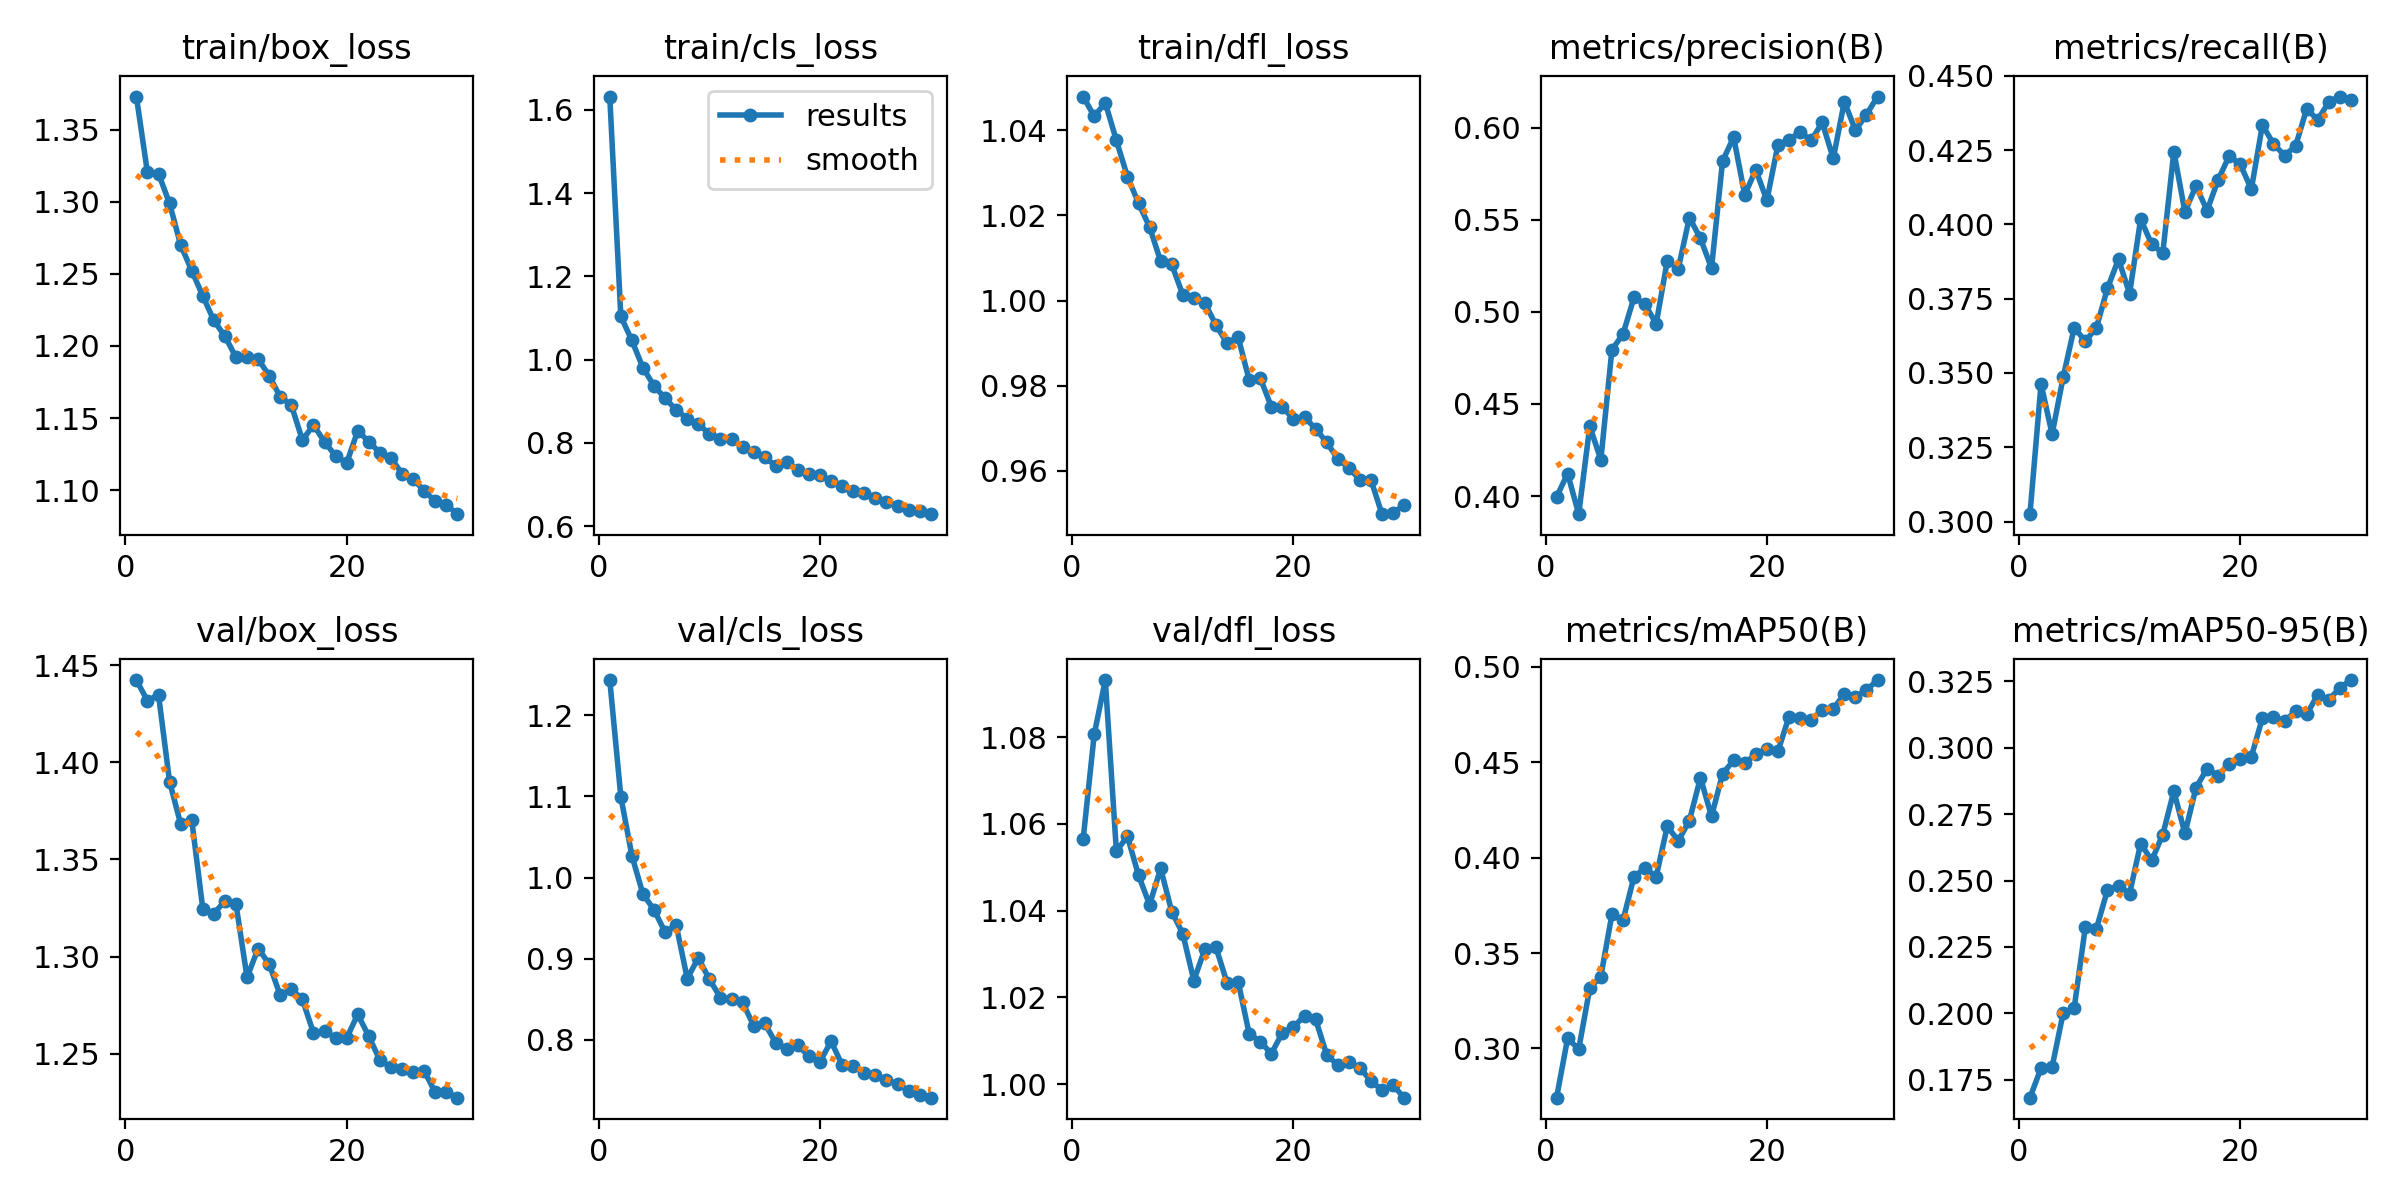


2. Confusion Matrix (Diagonal values should be high):
   - Shows if the model confuses 'Bus' with 'Truck', etc.


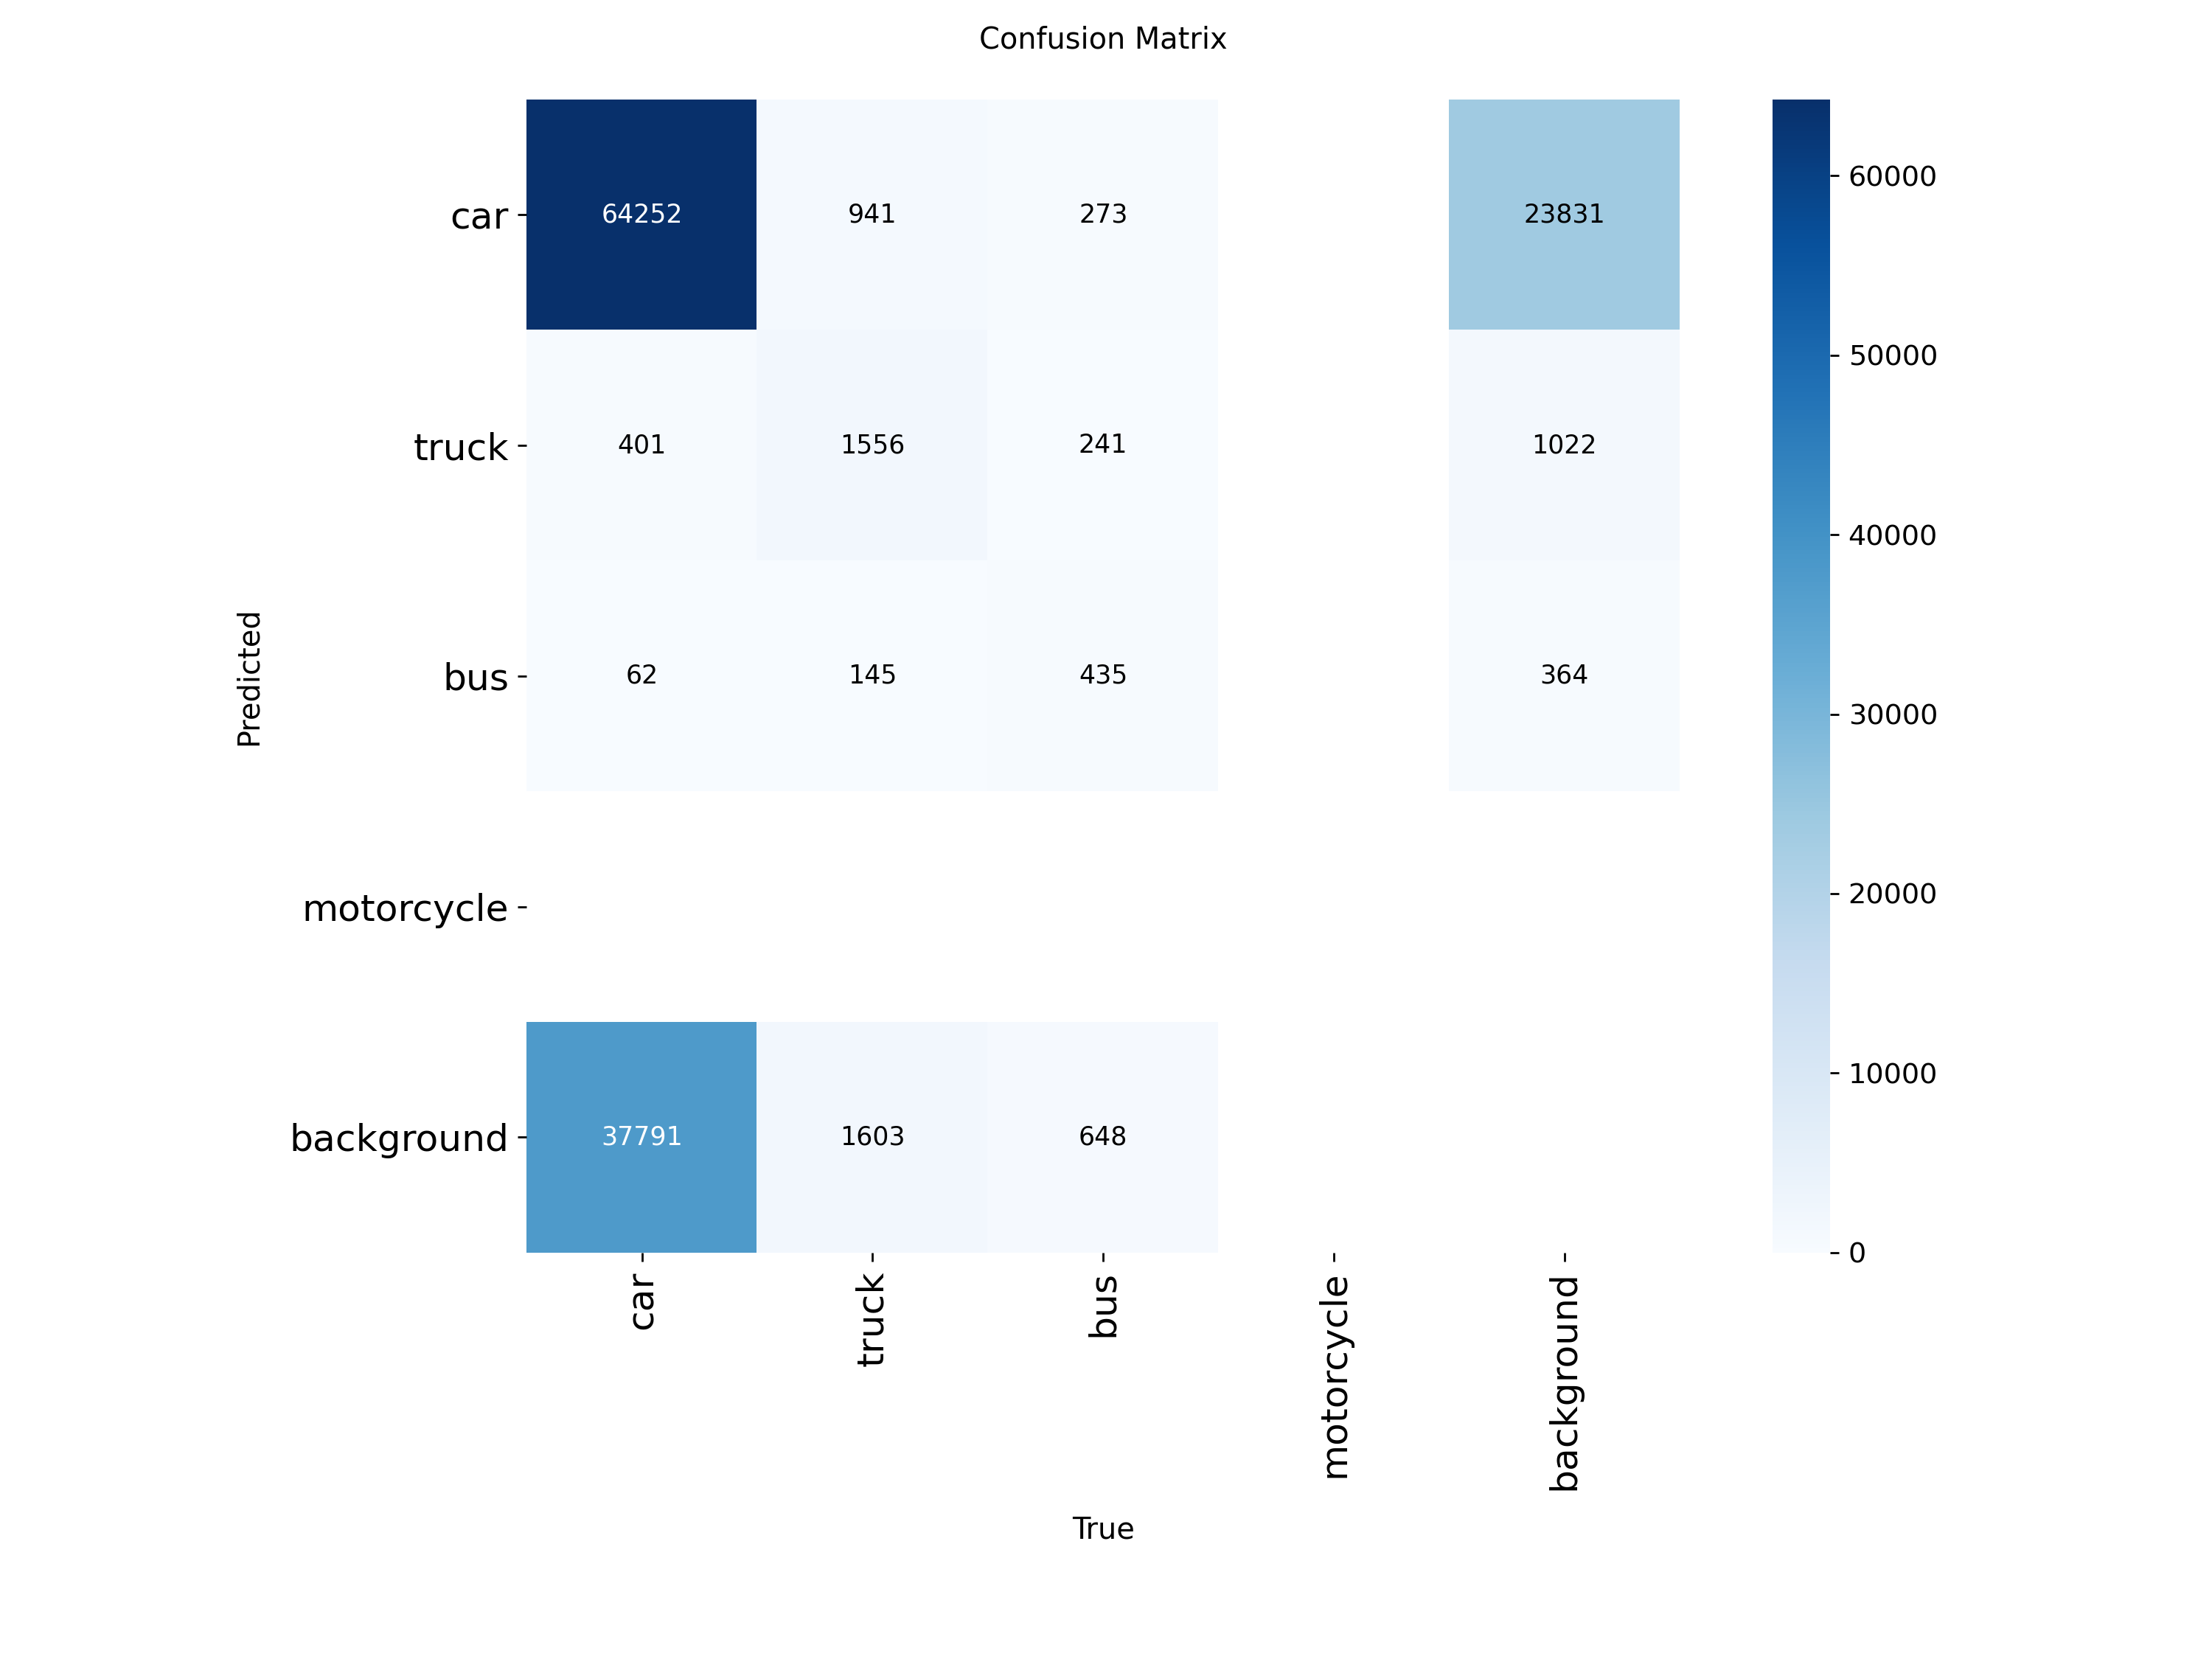

In [7]:
from IPython.display import Image, display

print(" PERFORMANCE ANALYSIS")
print("=======================")

print("1. Training Metrics (Loss should decrease, mAP should increase):")
display(Image(filename=f'/kaggle/working/atcc_project/run_full_data/results.png'))

print("\n2. Confusion Matrix (Diagonal values should be high):")
print("   - Shows if the model confuses 'Bus' with 'Truck', etc.")
display(Image(filename=f'/kaggle/working/atcc_project/run_full_data/confusion_matrix.png'))

 Running ATCC System on 5 Test Images...

 Image: dac851b9-c153392c.jpg
------------------------------
   Car:        10
   Truck:      0
    Bus:        0
    Motorcycle: 0


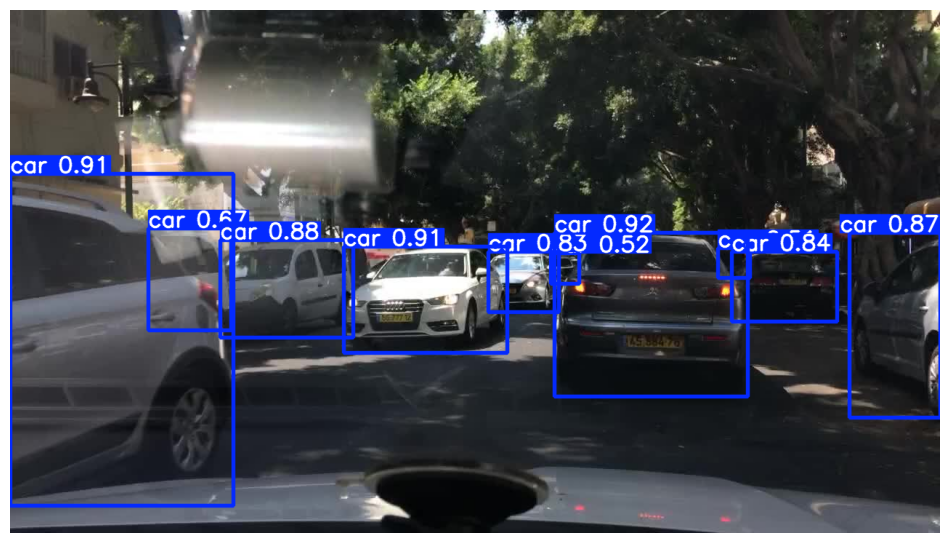

 Image: dc9b1eb8-063b88fb.jpg
------------------------------
   Car:        9
   Truck:      0
    Bus:        0
    Motorcycle: 0


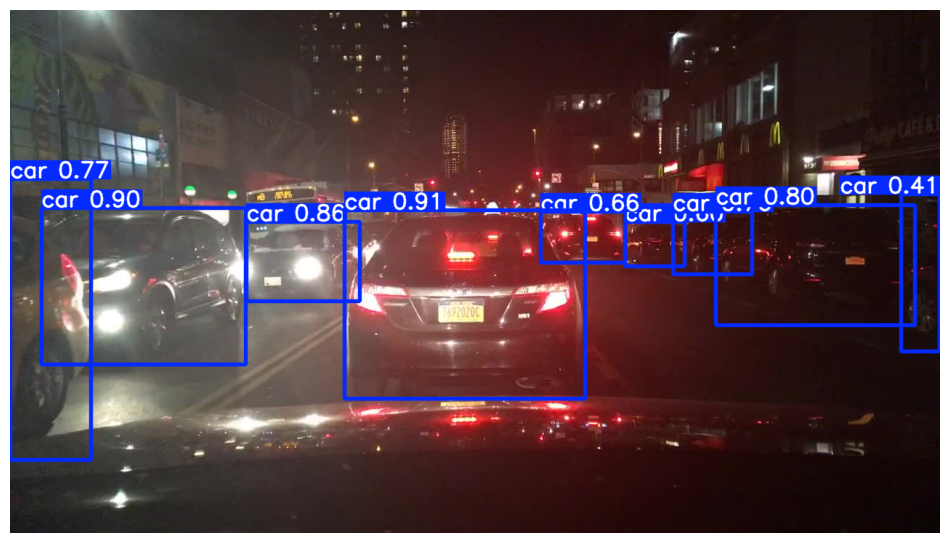

 Image: d22dc344-46571c2f.jpg
------------------------------
   Car:        6
   Truck:      0
    Bus:        0
    Motorcycle: 0


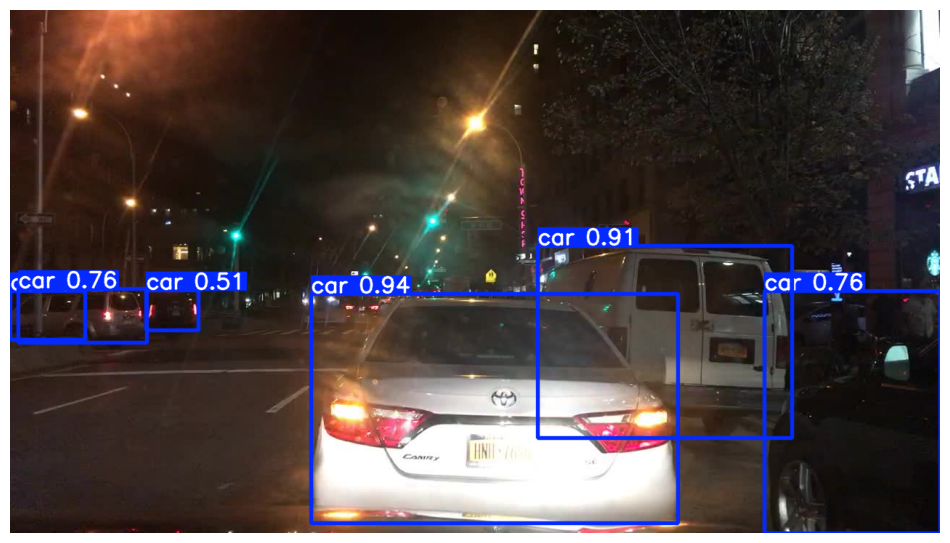

 Image: e19df6a4-7379be3c.jpg
------------------------------
   Car:        8
   Truck:      1
    Bus:        0
    Motorcycle: 0


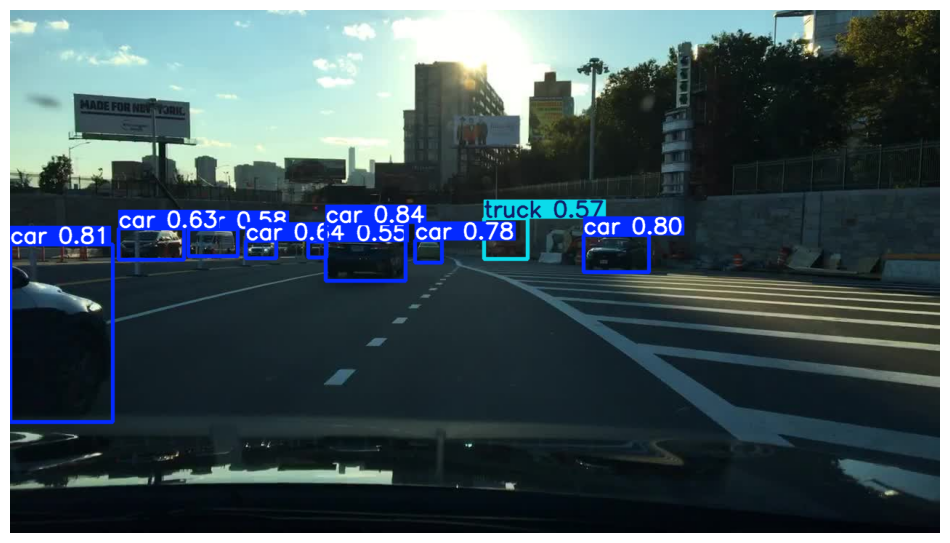

 Image: d32079ee-98db9786.jpg
------------------------------
   Car:        0
   Truck:      0
    Bus:        0
    Motorcycle: 0


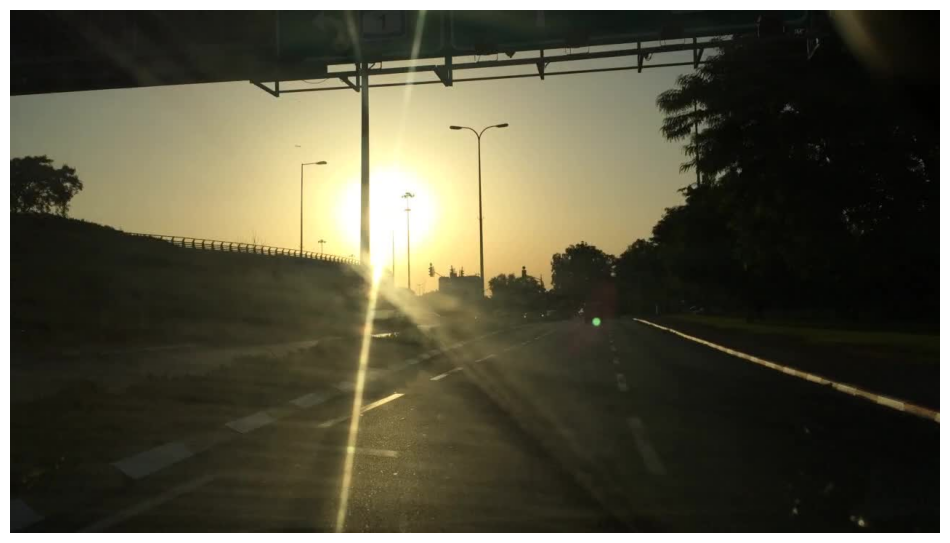

In [9]:

best_model = YOLO('/kaggle/working/atcc_project/run_full_data/weights/best.pt')

test_folder = "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test"
test_images = glob.glob(f"{test_folder}/*.jpg")

selected_images = random.sample(test_images, 5)

print(f" Running ATCC System on {len(selected_images)} Test Images...\n")
classes = ["car", "truck", "bus", "motorcycle"]

for img_path in selected_images:
    results = best_model.predict(img_path, conf=0.35, verbose=False)[0]

    counts = {c: 0 for c in classes}
    
    det_classes = results.boxes.cls.cpu().numpy().astype(int)
    
    for cls_id in det_classes:
        c_name = results.names[cls_id]
        if c_name in counts:
            counts[c_name] += 1
            
    print(f" Image: {os.path.basename(img_path)}")
    print("-" * 30)
    print(f"   Car:        {counts['car']}")
    print(f"   Truck:      {counts['truck']}")
    print(f"    Bus:        {counts['bus']}")
    print(f"    Motorcycle: {counts['motorcycle']}")
  
    
    # Plot the image with bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(results.plot()[:, :, ::-1])
    plt.axis('off')
    plt.show()